# Observing Dark Worlds

## Goal:
Observing Dark World is a astrophysics problem of detecting positions of dark matter halos by using its gravitational lensing effect, typically meas it destort the light of background galaxy which passes close to the Dark Matter.
It's a hard problem because detecting dark matter is difficult and it's hard to recognize the distortion.
![Gravitational_Lensing](images/reorderdarkmatter.png)

## Data
To solve the position of the core of dark matter, we gather 300 telescope scan data, each telescope data contains 300 to 800 galaxy data. Each galaxy data are consist of x and y corrdinates and two ellipiticity data, represents the elongation of the galaxies, cased by the spacetime wrap from dark matter halos. (Salimans, 2012)

# imports

In [35]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tensorflow.contrib.distributions as ds
from edward.models import Normal, Uniform, InverseGamma, Empirical

# import data
* all_sky_star = []: skies
    * all_sky_star[i]: one sky
        * all_sky_star[i][0]: galaxy name
        * all_sky_star[i][1]: galaxy x position
        * all_sky_star[i][2]: galaxy y position
        * all_sky_star[i][3]: galaxy E1
        * all_sky_star[i][4]: galaxy E2
* all_sky_halo = []:halos
    * all_sky_halo[i] :halo for sky i
        * all_sky_halo[i][0]: sky name
        * all_sky_halo[i][1]: number of halos
        * all_sky_halo[i][2]: halo1 x
        * all_sky_halo[i][3]: halo1 y
        * ...
        * all_sky_halo[i][7]: halo3 y

In [14]:
num_of_sky = 300
file_path = "datasets"
all_sky_star = []

for sky in np.arange(1, num_of_sky + 1, 1):
    sky_path = "Train_Skies/Training_Sky" + str(sky) + ".csv"
    halo_path = "Training_halos.csv"
    star = pd.read_csv(path + "/" + sky_path)
    all_sky_star.append(star.values)
star.head()
#all_sky_halo = all_sky_halo.values


,GalaxyID,x,y,e1,e2
0,Galaxy1,1630.16,1027.12,-0.194881,0.045802
1,Galaxy2,1056.72,126.24,-0.235309,0.176257
2,Galaxy3,3903.84,2612.56,0.213914,-0.052132
3,Galaxy4,2120.96,2098.82,0.272938,-0.045578
4,Galaxy5,1549.02,2042.28,-0.507234,0.086598


In [15]:
all_sky_halo_data = pd.read_csv(path + "/" + halo_path)
all_sky_halo = all_sky_halo_data.values
all_sky_halo_data.head()


,SkyId,numberHalos,x_ref,y_ref,halo_x1,halo_y1,halo_x2,halo_y2,halo_x3,halo_y3
0,Sky1,1,1086.80,1114.61,1086.80,1114.61,0.0,0.0,0.0,0.0
1,Sky2,1,3477.71,1907.33,3477.71,1907.33,0.0,0.0,0.0,0.0
2,Sky3,1,2315.78,1081.95,2315.78,1081.95,0.0,0.0,0.0,0.0
3,Sky4,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
4,Sky5,1,3091.65,2001.08,3091.65,2001.08,0.0,0.0,0.0,0.0


# data processing
## single_sky_data
* sky_num = []:    No. of test sky
* single_sky_halo_xy: 2d position of halo in test sky
* single_sky_e1[i]:   e1 of i_th galaxy in test sky
* single_sky_e2[i]:   e2 of i_th galaxy in test sky
* single_sky_a1[i]:   a1 of i_th galaxy in test sky
* single_sky_a2[i]:   a2 of i_th galaxy in test sky

In [49]:
sky_num = 8
single_sky_halo_xy = np.array(all_sky_halo[sky_num, 2:4], dtype=np.float32)
single_sky_e1 = np.array(all_sky_star[sky_num][:, 3], dtype=np.float32)
single_sky_e2 = np.array(all_sky_star[sky_num][:, 4], dtype=np.float32)
l2_e1e2 = np.sqrt(single_sky_e1**2 + single_sky_e2**2)
q = ((1. + l2_e1e2) / (1 - l2_e1e2))**2
single_sky_a1 = np.sqrt(q / (1 + q))
single_sky_b1 = np.sqrt(1. / (1 + q))
single_sky_pos_xy = np.array(all_sky_star[sky_num][:, 1:3])
num_of_glxy = single_sky_pos_xy.shape[0]

# distribution check

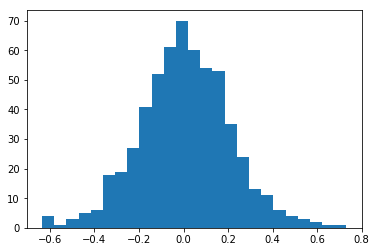

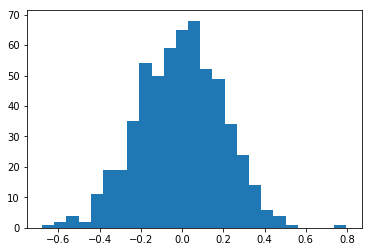

In [41]:
plt.clf()
plt.hist(single_sky_e1,25)
plt.show()
plt.hist(single_sky_e2,25)
plt.show()

# tangential funtion

In [47]:
def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:, 1], delta[:, 0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

# Model 1

In [48]:
N = num_of_glxy
glxy_pos_xy = tf.placeholder(tf.float32, [N, 2])
# halo_pos_xy = Uniform(low=[0.,0.],high=[4200., 4200.])
halo_pos_xy = Normal(loc=tf.constant([2100., 2100.]), scale=tf.constant(20.0))
sigma = tf.constant(.05)  # InverseGamma(20.0, 1.0)
l2diff_halo_glxy = tf.sqrt(tf.reduce_sum(tf.square(glxy_pos_xy - halo_pos_xy),
                           reduction_indices=1))
sess = ed.get_session()
glxy_e1 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 0), scale=sigma)
glxy_e2 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 1), scale=sigma)

# Inference

## Variational Inference

In [ ]:
def normal_qx():
    return Normal(tf.random_normal([2], mean=2100.), scale=tf.nn.softplus(
                  tf.Variable(tf.random_normal([2]))))


e1_in = single_sky_e1.reshape(N).tolist()
e2_in = single_sky_e2.reshape(N).tolist()
q_halo_pos_xy = normal_qx()
inference = ed.KLqp({halo_pos_xy: q_halo_pos_xy},
                    data={glxy_pos_xy: single_sky_pos_xy,
                    glxy_e1: e1_in, glxy_e2: e2_in})
inference.run(n_iter=10000, n_samples=10)

# MCMC

In [53]:
# Inference
def constraints_normal(T):
    return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2],
                      mean=[2100., 2100.], stddev=100.)), 0), 4200)


T = 3000
q_halo_pos_xy = Empirical(params=constraints_normal(T))
# qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
inference = ed.SGHMC({halo_pos_xy: q_halo_pos_xy},
                     data={glxy_pos_xy: single_sky_pos_xy,
                     glxy_e1: e1_in, glxy_e2: e2_in})
inference.run(step_size=15.)

3000/3000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.000


# Criticism

[ 2615.65063477  2553.6027832 ] [ 60.50963593  75.36395264]


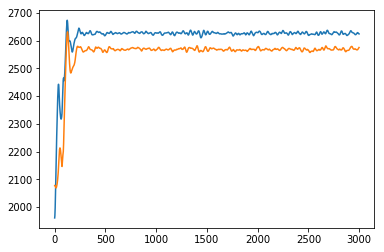

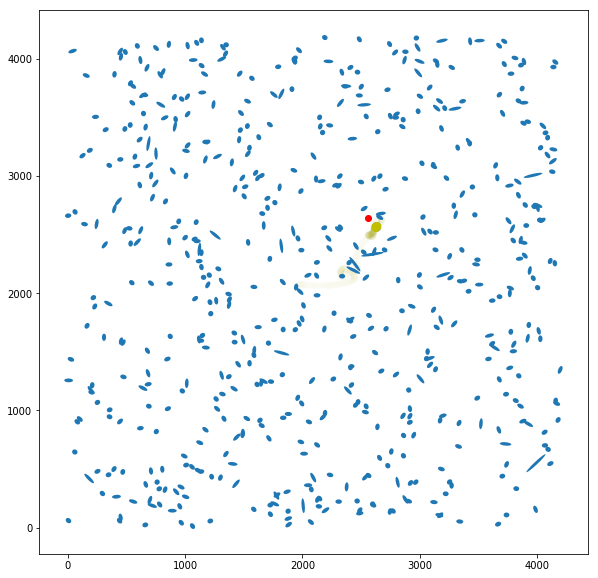

In [56]:
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i, :]
        x, y = _g[0], _g[1]
        d = np.sqrt(_g[2]**2 + _g[3]**2)
        a = 1.0 / (1 - d)
        b = 1.0 / (1 + d)
        theta = np.degrees(np.arctan2(_g[3], _g[2]) * 0.5)
        ax.add_patch(Ellipse(xy=(x, y), width=size_multiplier * a,
                     height=size_multiplier * b, angle=theta))
    ax.autoscale_view(tight=True)
    return fig

mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
print(mean, stddev)
samples = sess.run(q_halo_pos_xy.params)
# plt.hist(samples, bins='auto')
# plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:, 1:])
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.015, c="y")
plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


# Criticism 2

3000/3000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000
[ 2423.27709961  2330.52172852] [ 488.45852661  553.12884521]
3000/3000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.000
[ 2315.          2127.06811523] [ 351.03491211  147.61949158]
3000/3000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.000
[ 2491.1184082   2521.14477539] [ 403.56860352   99.88458252]
3000/3000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.000
[  446.32241821  3192.22607422] [  6.67408371  21.28545189]
3000/3000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.000
[ 2276.16894531  2045.60717773] [ 220.37519836  293.47171021]
3000/3000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.000
[ 2309.19140625  2098.26708984] [ 144.86981201  123.32250214]
3000/3000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.0001s | Acceptance Ra
[ 2333.58740234  

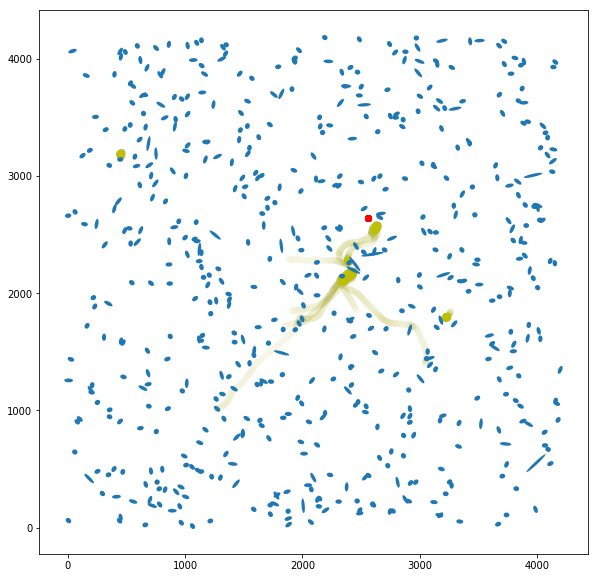

In [63]:
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:, 1:])
for i in np.arange(400, 4001, 1000):
    for j in np.arange(400, 4001, 1000):
        def constraints_normal(T):
            return tf.minimum(tf.maximum(tf.Variable(tf.random_normal(
                              [T, 2], mean=[i, j], stddev=1.)), 0), 4200)

        T = 3000
        q_halo_pos_xy = Empirical(params=constraints_normal(T))
        # qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
        inference = ed.SGHMC({halo_pos_xy: q_halo_pos_xy},
                             data={glxy_pos_xy: single_sky_pos_xy,
                             glxy_e1: e1_in, glxy_e2: e2_in})
        inference.run(step_size=5.)

        mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
        print(mean, stddev)
        samples = sess.run(q_halo_pos_xy.params)
        # plt.hist(samples, bins='auto')
        # plt.show()

        # Trace plot.
        # plt.plot(samples)
        # plt.show()

        plt.scatter(samples[200:, 0], samples[200:, 1], alpha=0.015, c="y")
        plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


# Neural Network for distance funtion

## concatnate data

In [108]:
sky0_e1 = np.array(all_sky_star[0][:,3],dtype=np.float32)
sky0_e2 = np.array(all_sky_star[0][:,4],dtype=np.float32)
sq = np.sqrt(sky0_e1**2+sky0_e2**2)
q = ((1.+sq)/(1-sq))**2
sky0_a1 = np.sqrt(q/(1+q))
sky0_b1 = np.sqrt(1./(1+q))
select = sky0_a1/sky0_b1>2
select = select.reshape(select.shape[0])

conc_glxy_xy = all_sky_star[0][select,1:3]
conc_halo_xy = np.ones(all_sky_star[0][select,1:3].shape)*all_sky_halo[0,2:4]
conc_glxy_e1_e2 = all_sky_star[0][select,3:5]

for sky2 in np.arange(1,300,1):
    e1,e2 = np.array(all_sky_star[sky2][:,3:4],dtype=np.float32),np.array(all_sky_star[sky2][:,4:5],dtype=np.float32)
    sq = np.sqrt(e1**2+e2**2)
    q = ((1.+sq)/(1-sq))**2
    a1 = np.sqrt(q/(1+q))
    b1 = np.sqrt(1./(1+q))
    select = a1/b1>2
    select = select.reshape(select.shape[0])
    conc_glxy_xy = np.concatenate((conc_glxy_xy,all_sky_star[sky2][select,1:3]),axis = 0)
    conc_glxy_e1_e2 = np.concatenate((conc_glxy_e1_e2,all_sky_star[sky2][select,3:5]),axis = 0)
    conc_halo_xy = np.concatenate((conc_halo_xy,np.ones(all_sky_star[sky2][select,1:3].shape)*halo[sky2,2:4]),axis = 0)
print(conc_glxy_xy.shape)
print(conc_halo_xy.shape)
print(conc_glxy_e1_e2.shape)
num_all_glxy = conc_glxy_xy.shape[0]

(50845, 2)
(50845, 2)
(50845, 2)


In [118]:
N = num_all_glxy

# Model

glxy_pos_xy = tf.placeholder(tf.float32, [N, 2])

# halo_pos_xy = Uniform(low=[0.,0.],high=[4200., 4200.])
halo_pos_xy = tf.placeholder(tf.float32, [N, 2])
# halo_pos_xy = [2315.61, 1082.86]
# m = Uniform(low=10.,high=1000.)
m = 100

l2diff = tf.sqrt(tf.reduce_sum(tf.square(glxy_pos_xy - halo_pos_xy), reduction_indices=1))/4200.

sess = ed.get_session()

w0 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
b0 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
w1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
#b1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
w2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
#b2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
#b3 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=(tf.multiply(l2diff**(-1),w0) + tf.multiply(l2diff**(1), w1) + tf.multiply(l2diff**(2), w2) + b0), scale=tf.ones(N))
mu =y

e1_var = tf.multiply(tangential(glxy_pos_xy, halo_pos_xy , 0),mu)
e2_var = tf.multiply(tangential(glxy_pos_xy, halo_pos_xy , 1),mu)
sess2 =tf.Session()



# inference

In [116]:
e1_in = conc_glxy_e1_e2[:,0].reshape(N).tolist()
e2_in = conc_glxy_e1_e2[:,1].reshape(N).tolist()

qw0 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw2 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb2 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb3 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
             
inference = ed.KLqp({w0: qw0, b0: qb0, w1: qw1, w2: qw2}, data={halo_pos_xy: conc_halo_xy, glxy_pos_xy: conc_glxy_xy,
                     e1_var: e1_in, e2_var: e2_in})
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: -0.000


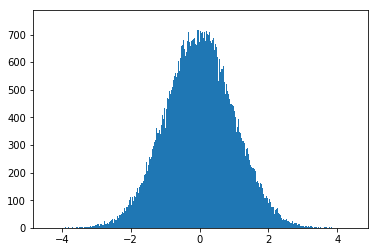

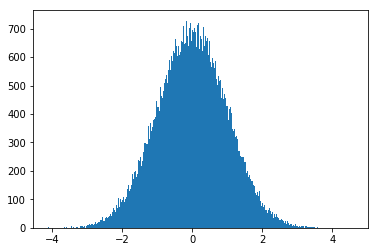

Tensor("Mul_61:0", shape=(50845,), dtype=float32)


In [117]:
def visualise(X_data, y_data, w, b, n_samples=10):
    w_samples = w.sample(n_samples)[:, 0].eval()
    b_samples = b.sample(n_samples).eval()
    plt.scatter(X_data[:, 0], y_data)
    inputs = np.linspace(-8, 8, num=400)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        plt.plot(inputs, output)
    plt.show()
#visualise(e1_e2[:,:1], e1_e2[:,1:], qw0, qb0)

w_samples = qw2.sample(100000)[:, 0].eval()
plt.hist(w_samples,500)
plt.show()
w_samples =w2.sample(100000)[:, 0].eval()
plt.hist(w_samples,500)
plt.show()
print(e1_var)